# Forecast of Next 2 Months Using CNN-LSTM

In [69]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import style
style.use('ggplot')

## Dataset

### Importing Dataset

In [70]:
df = pd.read_csv("Oil Data.csv")
df.head()

,Date,Price,Open,High,Low,Volume,Chg%
0,14-Oct-22,85.61,89.27,89.73,85.20,0,-3.93%
1,13-Oct-22,89.11,87.08,89.66,85.56,298.03K,2.11%
2,12-Oct-22,87.27,88.67,90.07,86.28,332.27K,-2.33%
3,11-Oct-22,89.35,91.14,91.35,87.91,333.16K,-1.95%
4,10-Oct-22,91.13,93.48,93.64,90.54,289.51K,-1.63%


In [71]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values('Date')
df.head()

,Date,Price,Open,High,Low,Volume,Chg%
209,2022-01-03,76.08,75.69,76.46,74.27,317.63K,1.16%
208,2022-01-04,76.99,76.02,77.64,75.70,372.85K,1.20%
207,2022-01-05,77.85,77.18,78.58,76.51,397.90K,1.12%
206,2022-01-06,79.46,77.24,80.24,76.73,476.67K,2.07%
205,2022-01-07,78.90,79.62,80.47,78.52,414.43K,-0.70%


In [72]:
df.describe()

,Price,Open,High,Low
count,210.000000,210.000000,210.000000,210.000000
mean,97.857476,97.838238,100.162667,95.449524
std,11.520578,11.657990,12.038758,10.985885
min,76.080000,75.690000,76.460000,74.270000
25%,88.457500,88.180000,90.235000,86.637500
50%,96.130000,96.360000,98.910000,94.150000
75%,107.657500,107.392500,109.750000,104.005000
max,123.700000,124.660000,130.500000,120.790000


Dropping all the days with missing values

In [73]:
df.dropna(axis = 0, inplace=True)
df.shape

(210, 7)

In [74]:
df.index = df['Date']
df = df.drop(["High", "Open", "Low", "Volume", "Chg%", "Date"], axis = 1)
df.head()

,Price
Date,
2022-01-03,76.08
2022-01-04,76.99
2022-01-05,77.85
2022-01-06,79.46
2022-01-07,78.90


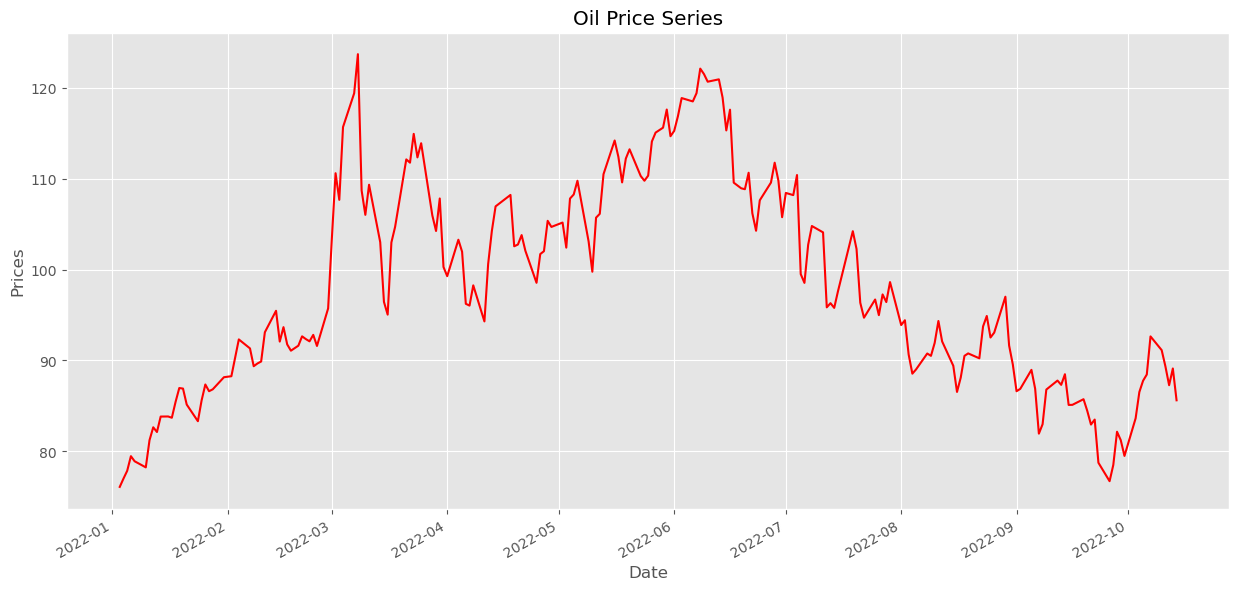

In [75]:
# Plot the price of Oil
df["Price"].plot(figsize=(15, 7),color='r')
plt.ylabel("Prices")
plt.title("Oil Price Series")
plt.show()

### Z-score Standardization

In [76]:
#Data Preprocesing Using Z-score technique
from scipy.stats import zscore
mdata = df.apply(zscore)
mdata.head()

mean_p = df["Price"].mean() # Mean
s_p = df["Price"].std() # Standard Deviation



In [77]:
len(df.index) # 0 to 209

210

In [78]:
# Making matrices of 10*1 shape
mdata=np.array(mdata)
dataset=[] # Prices 
label=[] # Day/Time-step
# The input training set data is a three-dimensional data vector (None, 10, 1), in which 
# 10 is the size of the time-step and 8 is the 8 features of the input dimension.
for i in range(len(df.index) - 11): # Over range(199), i.e. 0 to 198
  dataset.append(mdata[i:i+10]) # Till 208, 199 sets
  label.append(mdata[i+11]) # mdata[11 to 209]
label = np.array(label)
dataset = np.array(dataset)

In [79]:
dataset[0]

array([[-1.89482804],
       [-1.8156502 ],
       [-1.74082279],
       [-1.60073892],
       [-1.64946374],
       [-1.70775951],
       [-1.44760376],
       [-1.32405152],
       [-1.369296  ],
       [-1.22138136]])

In [80]:
len(label)

199

In [81]:
# Splitting Data into test, validation, train
train_ratio = 0.8
val_train = 1
r=int(len(dataset)*train_ratio)
s=int(len(dataset)*val_train)
X_train=dataset[:r]
X_val=dataset[r:s]
y_train=label[:r]
y_val=label[r:s]

### CNN-LSTM Model

In [82]:
# Model
model = keras.models.Sequential()
model.add(layers.Conv1D(32,1,padding='same',activation='tanh',input_shape=(10,1)))
model.add(layers.MaxPool1D(pool_size=1,padding='same'))
model.add(layers.LSTM(64,activation='tanh',))
model.add(layers.Dense(1))

In [83]:
model.compile(loss='mean_absolute_error',optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 10, 32)            64        
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 10, 32)           0         
 1D)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 64)                24832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24,961
Trainable params: 24,961
Non-trainable params: 0
_________________________________________________________________


In [85]:
print("Training data: " + str(len(y_train)))

Training data: 159


#### Training over complete data

In [86]:
#Training
model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100,batch_size=64)

Epoch 1/100
3/3 [==============================] - 1s 90ms/step - loss: 0.7885 - val_loss: 0.8090
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.6210 - val_loss: 0.6307
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 0.4603 - val_loss: 0.4711
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3876 - val_loss: 0.3480
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3929 - val_loss: 0.3007
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3906 - val_loss: 0.2970
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3586 - val_loss: 0.3056
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3452 - val_loss: 0.3240
Epoch 9/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3490 - val_loss: 0.3333
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 0.3537 - val_loss: 0.3281
Epoch 11/100
3/3 [=========

Prediction Dates Dataset

In [87]:

from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2022, 10, 15)
end_date = date(2022, 12, 31)

In [88]:
ds = dataset.copy().tolist()
l = label.copy().tolist()

Prediciting Next Day Price (15th October) and recreating the training dataset with predicted price

In [89]:
ds.append(mdata[len(df.index)-10:len(df.index)]) # Appending the last set from 200 to 209

In [90]:
y_pred = model.predict(ds)

7/7 [==============================] - 0s 1ms/step


In [91]:
l = y_pred # Price of 15 Oct predicted

In [92]:
len(l)

200

In [93]:
l[199]

array([-0.8144655], dtype=float32)

In [94]:
label[198]

array([-1.06563594])

In [95]:
i = len(df.index) - 11

### Forecasting Next 2 Months
Recreating the training dataset each time after predicting the price for the next day

In [96]:
for single_date in daterange(start_date, end_date):
    zprice = l[i][0]
    price = (zprice * s_p) + mean_p
    
    temp = pd.DataFrame({'Price': price}, index=[single_date])
    df = pd.concat([df, temp])
    
    #Data Re - Preprocesing Using Z-score technique
    mdata = df.apply(zscore)
    mdata.head()

    mean_p = df["Price"].mean()
    s_p = df["Price"].std()
    
    #Making matrices of 10*1 shape
    mdata=np.array(mdata)
    dataset=[]
    label=[]
    for i in range(len(df.index) - 11): # Over range(199), i.e. 0 to 198
        dataset.append(mdata[i:i+10]) # Till 208, 199 sets
        label.append(mdata[i+11][0]) # mdata[11 to 209]
    label = np.array(label)
    dataset = np.array(dataset)
    
    #Splitting Data into test, validation, train
    train_ratio = 0.8
    val_train = 1
    r=int(len(dataset)*train_ratio)
    s=int(len(dataset)*val_train)
    X_train=dataset[:r]
    X_val=dataset[r:s]
    y_train=label[:r]
    y_val=label[r:s]
    
    #Training
    model.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=100,batch_size=64)
    
    ds = dataset.copy().tolist()
    l = label.copy().tolist()
    
    ds.append(mdata[len(df.index)-10:len(df.index)]) # Appending the last price into training dataset
    y_pred = model.predict(ds)
    l = y_pred # Price of start_date + 1 predicted
    i = i+1    
    

Epoch 1/100
3/3 [==============================] - 1s 181ms/step - loss: 0.2886 - val_loss: 0.2793
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2860 - val_loss: 0.2765
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2871 - val_loss: 0.2848
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2843 - val_loss: 0.2851
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2844 - val_loss: 0.2804
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2841 - val_loss: 0.2808
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2836 - val_loss: 0.2833
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2842 - val_loss: 0.2971
Epoch 9/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2844 - val_loss: 0.2888
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2837 - val_loss: 0.2802
Epoch 11/100
3/3 [=========

In [97]:
df

,Price
2022-01-03 00:00:00,76.080000
2022-01-04 00:00:00,76.990000
2022-01-05 00:00:00,77.850000
2022-01-06 00:00:00,79.460000
2022-01-07 00:00:00,78.900000
...,...
2022-12-26,104.291969
2022-12-27,102.310261
2022-12-28,102.605311
2022-12-29,103.647685


In [98]:
real = df.iloc[0:210]

In [99]:
predicted = df.iloc[209:287]

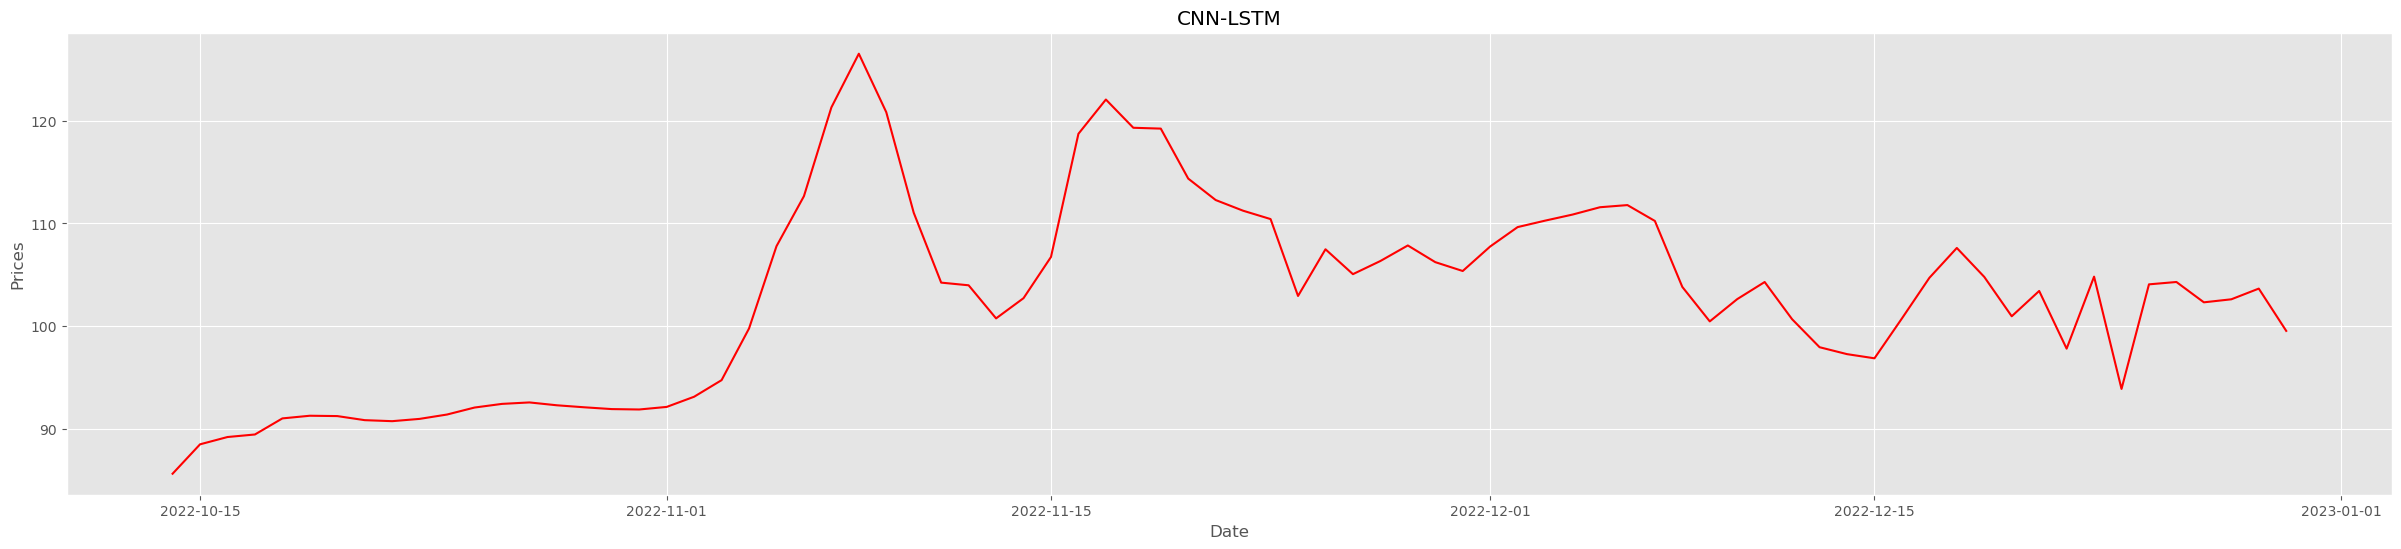

In [105]:
#Plotting Result
plt.figure(figsize = (30,6))
plt.plot(predicted["Price"], color = 'r')
plt.ylabel("Prices")
plt.title("Oil Price Series")
plt.xlabel('Date')
plt.title("CNN-LSTM")
plt.show()

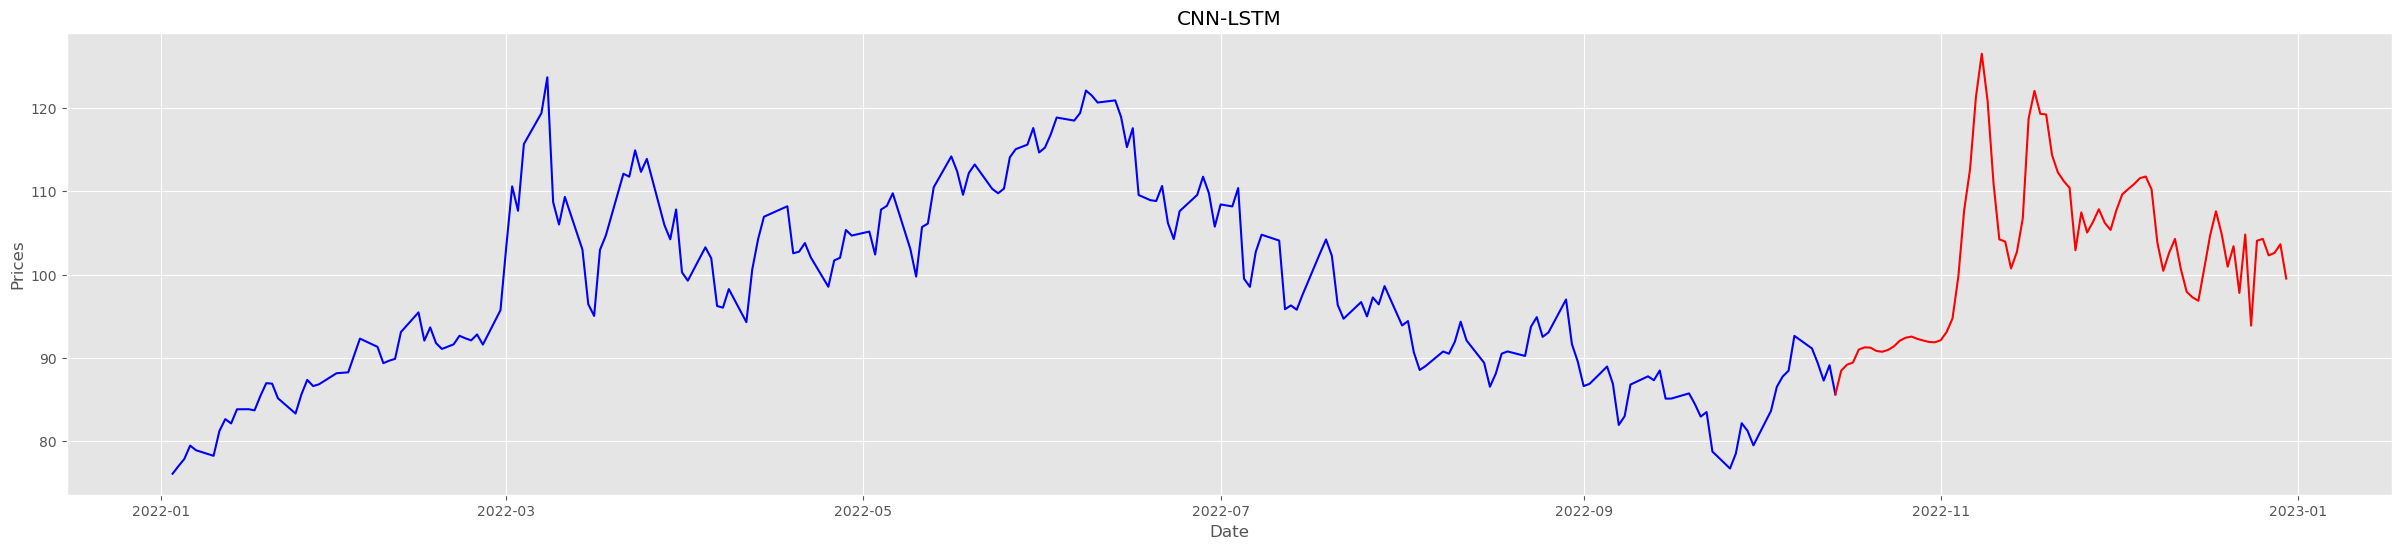

In [106]:
#Plotting Complete Oil Price
plt.figure(figsize = (30,6))
plt.plot(real["Price"], color = 'b')
plt.plot(predicted["Price"], color = 'r')
plt.ylabel("Prices")
plt.title("Oil Price Series")
plt.xlabel('Date')
plt.title("CNN-LSTM")
plt.show()

In [101]:
data_req = df.iloc[227:]
data_req


,Price
2022-11-01,92.119361
2022-11-02,93.111610
2022-11-03,94.727800
2022-11-04,99.761529
2022-11-05,107.777047
2022-11-06,112.653376
2022-11-07,121.301552
2022-11-08,126.533683
2022-11-09,120.833806
2022-11-10,111.038391


In [102]:
data_req.to_csv('Predicted Price.csv')